In [213]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import random

In [214]:
square_length = 28
boundary_bump = 4


def vertical_boundary_tensor_image():
    vertical_boundary_image = [[]] 
    boundary_position = random.randint(boundary_bump, square_length - boundary_bump)
    for pixel_row in range(square_length):
        vertical_boundary_image[0].append([])
        for pixel_column in range(square_length):
            if pixel_column < boundary_position:
                vertical_boundary_image[0][pixel_row].append(np.float32(1))
            else:
                vertical_boundary_image[0][pixel_row].append(np.float32(0))

    vertical_boundary_tensor = torch.tensor(vertical_boundary_image)
    return vertical_boundary_tensor

def horizontal_boundary_tensor_image():
    horizontal_boundary_image = [[]] 
    boundary_position = random.randint(boundary_bump, square_length - boundary_bump)
    for pixel_row in range(square_length):
        horizontal_boundary_image[0].append([])
        if pixel_row < boundary_position:
            for pixel_column in range(square_length):
                horizontal_boundary_image[0][pixel_row].append(np.float32(1))
        else:
            for pixel_column in range(square_length):
                horizontal_boundary_image[0][pixel_row].append(np.float32(0))

    horizontal_boundary_tensor = torch.tensor(horizontal_boundary_image)
    return horizontal_boundary_tensor

In [215]:
class DummyDataset(Dataset):
    def __init__(self, transform=None):
        self.transform = transform
        self.all_imgs = []
        for i in range(50):
            self.all_imgs.append(vertical_boundary_tensor_image())
            self.all_imgs.append(horizontal_boundary_tensor_image())

    def __len__(self):
        return len(self.all_imgs)

    def __getitem__(self, idx):
        tensor_image = self.all_imgs[idx]
        return tensor_image, tensor_image

In [216]:
full_dataset = DummyDataset()

In [217]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5), (0.5))
    ])

transform = transforms.ToTensor()

mnist_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

data_loader = torch.utils.data.DataLoader(dataset=full_dataset,
                                          batch_size=20,
                                          shuffle=True)

In [218]:
dataiter = iter(data_loader)
images, labels = dataiter.__next__()
print(torch.min(images), torch.max(images))

tensor(0.) tensor(1.)


In [219]:
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()        
        # N, 1, 28, 28
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1), # -> N, 16, 14, 14
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1), # -> N, 32, 7, 7
            nn.ReLU(),
            nn.Conv2d(32, 64, 7) # -> N, 64, 1, 1
        )
        
        # N , 64, 1, 1
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 7), # -> N, 32, 7, 7
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1), # N, 16, 14, 14 (N,16,13,13 without output_padding)
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1), # N, 1, 28, 28  (N,1,27,27)
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
    
 
# Note: nn.MaxPool2d -> use nn.MaxUnpool2d, or use different kernelsize, stride etc to compensate...
# Input [-1, +1] -> use nn.Tanh

In [220]:
model = Autoencoder()

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),
                             lr=1e-3, 
                             weight_decay=1e-5)

In [221]:
# Point to training loop video
num_epochs = 50
outputs = []
for epoch in range(num_epochs):
    for (img, _) in data_loader:
        # img = img.reshape(-1, 28*28) # -> use for Autoencoder_Linear
        recon = model(img)
        loss = criterion(recon, img)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch:{epoch+1}, Loss:{loss.item():.4f}')
    outputs.append((epoch, img, recon))

"""
# Understand encoder model data structure            
full_dict = model.state_dict()
print("\n\n")
print(type(full_dict))
for key in full_dict:
    print(key)
    #print(encoder_dict[key].shape)

from collections import OrderedDict

encoder_keys = [k for k in full_dict.keys() if k.startswith('encoder')]
encoder_dict = OrderedDict()
for k in encoder_keys:
    encoder_dict[k] = full_dict[k]

print("\n\n")
print(type(encoder_dict))
for key in encoder_dict:
    print(key)
"""

torch.save(model.state_dict(), "autoencoder_model.pt")

Epoch:1, Loss:0.2496
Epoch:2, Loss:0.2415
Epoch:3, Loss:0.2226
Epoch:4, Loss:0.2161
Epoch:5, Loss:0.1823
Epoch:6, Loss:0.1657
Epoch:7, Loss:0.1339
Epoch:8, Loss:0.0855
Epoch:9, Loss:0.0724
Epoch:10, Loss:0.0424
Epoch:11, Loss:0.0311
Epoch:12, Loss:0.0230
Epoch:13, Loss:0.0238
Epoch:14, Loss:0.0110
Epoch:15, Loss:0.0142
Epoch:16, Loss:0.0189
Epoch:17, Loss:0.0104
Epoch:18, Loss:0.0100
Epoch:19, Loss:0.0128
Epoch:20, Loss:0.0128
Epoch:21, Loss:0.0068
Epoch:22, Loss:0.0078
Epoch:23, Loss:0.0106
Epoch:24, Loss:0.0075
Epoch:25, Loss:0.0052
Epoch:26, Loss:0.0053
Epoch:27, Loss:0.0090
Epoch:28, Loss:0.0068
Epoch:29, Loss:0.0056
Epoch:30, Loss:0.0045
Epoch:31, Loss:0.0023
Epoch:32, Loss:0.0034
Epoch:33, Loss:0.0026
Epoch:34, Loss:0.0019
Epoch:35, Loss:0.0017
Epoch:36, Loss:0.0017
Epoch:37, Loss:0.0010
Epoch:38, Loss:0.0026
Epoch:39, Loss:0.0024
Epoch:40, Loss:0.0016
Epoch:41, Loss:0.0008
Epoch:42, Loss:0.0019
Epoch:43, Loss:0.0018
Epoch:44, Loss:0.0009
Epoch:45, Loss:0.0004
Epoch:46, Loss:0.00

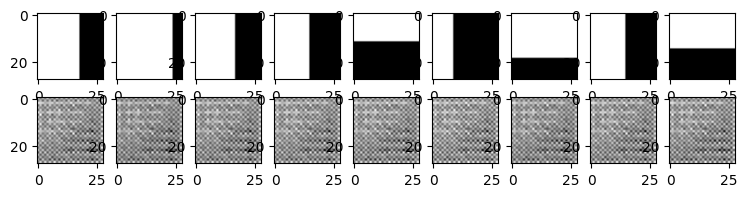

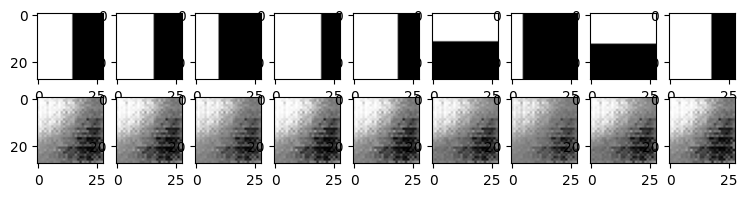

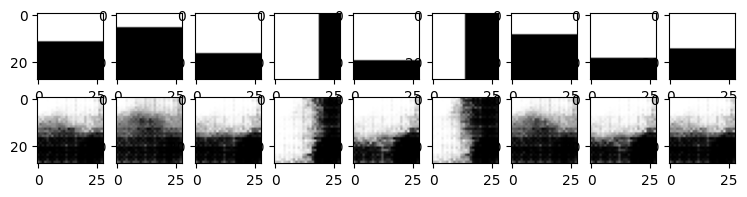

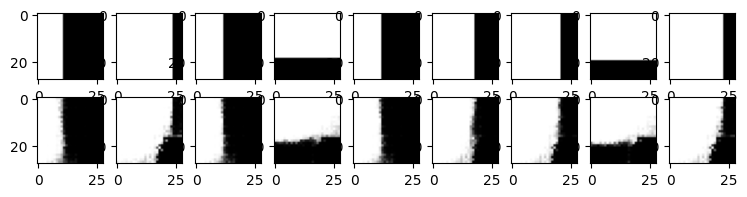

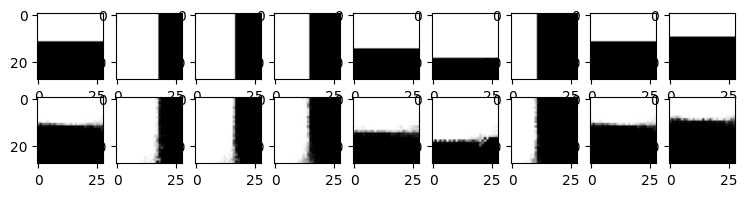

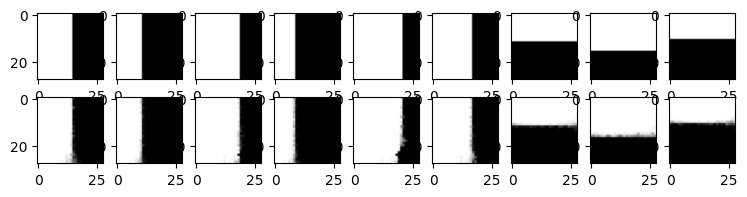

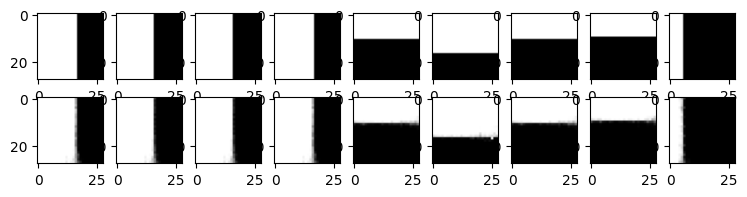

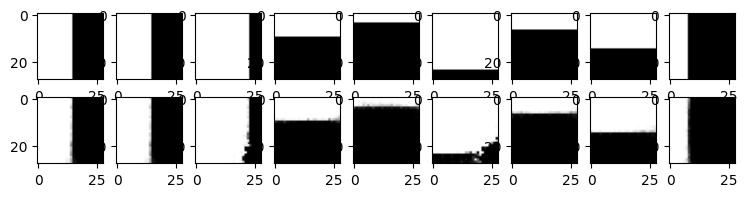

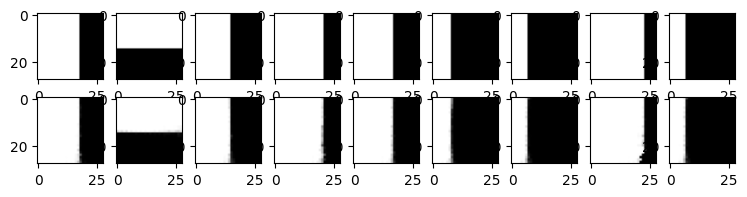

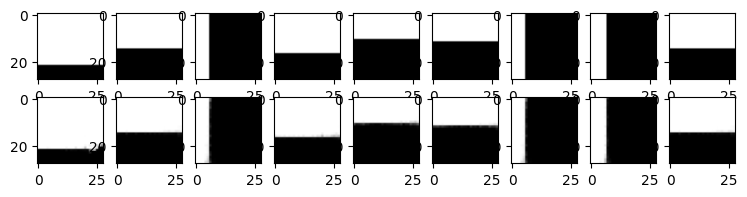

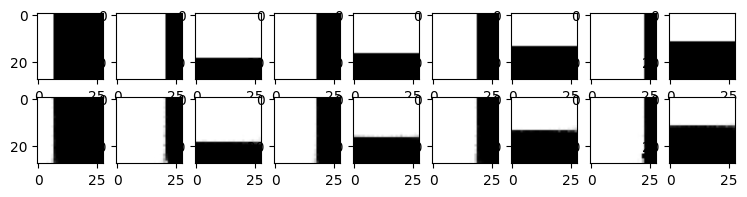

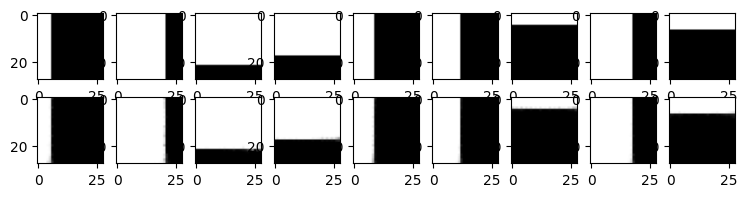

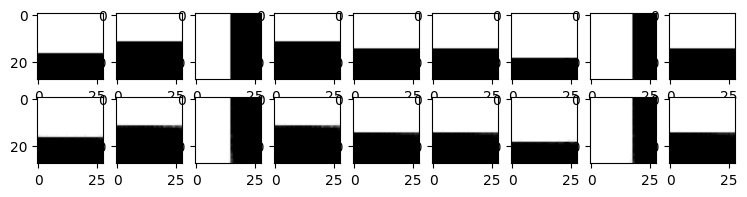

In [222]:
for k in range(0, num_epochs, 4):
    plt.figure(figsize=(9, 2))
    plt.gray()
    imgs = outputs[k][1].detach().numpy()
    recon = outputs[k][2].detach().numpy()
    for i, item in enumerate(imgs):
        if i >= 9: break
        plt.subplot(2, 9, i+1)
        # item = item.reshape(-1, 28,28) # -> use for Autoencoder_Linear
        # item: 1, 28, 28
        plt.imshow(item[0])
            
    for i, item in enumerate(recon):
        if i >= 9: break
        plt.subplot(2, 9, 9+i+1) # row_length + i + 1
        # item = item.reshape(-1, 28,28) # -> use for Autoencoder_Linear
        # item: 1, 28, 28
        plt.imshow(item[0])

In [223]:
def create_embedding(encoder, full_loader, embedding_dim, device):
    """
    Creates embedding using encoder from dataloader.
    encoder: A convolutional Encoder. E.g. torch_model ConvEncoder
    full_loader: PyTorch dataloader, containing (images, images) over entire dataset.
    embedding_dim: Tuple (c, h, w) Dimension of embedding = output of encoder dimesntions.
    device: "cuda" or "cpu"
    Returns: Embedding of size (num_images_in_loader + 1, c, h, w)
    """
    # Set encoder to eval mode.
    encoder.eval()
    # Just a place holder for our 0th image embedding.
    embedding = torch.randn(embedding_dim)
    
    # Again we do not compute loss here so. No gradients.
    with torch.no_grad():
        for batch_idx, (train_img, target_img) in enumerate(full_loader):
            # We can compute this on GPU. be faster
            train_img = train_img.to(device)
            
            # Get encoder outputs and move outputs to cpu
            enc_output = encoder(train_img).cpu()
            print(f"Embedding shape: {embedding.shape}") 
            print(f"Encoder output shape: {enc_output.shape}")
            # Keep adding these outputs to embeddings.
            embedding = torch.cat((embedding, enc_output), 0)
    
    # Return the embeddings
    return embedding

In [224]:
# Save the feature representations.
EMBEDDING_SHAPE = (64, 1, 28, 28) # This we know from our encoder - I changed this to 8 from 16 - why did that work!?

# We need feature representations for complete dataset not just train and validation.
# Hence we use full loader here.
embedding = create_embedding(model, data_loader, EMBEDDING_SHAPE, 'cpu')

# Convert embedding to numpy and save them
numpy_embedding = embedding.cpu().detach().numpy()
num_images = numpy_embedding.shape[0]

# Save the embeddings for complete dataset, not just train
flattened_embedding = numpy_embedding.reshape((num_images, -1))
np.save("data_embedding.npy", flattened_embedding)

Embedding shape: torch.Size([64, 1, 28, 28])
Encoder output shape: torch.Size([20, 1, 28, 28])
Embedding shape: torch.Size([84, 1, 28, 28])
Encoder output shape: torch.Size([20, 1, 28, 28])
Embedding shape: torch.Size([104, 1, 28, 28])
Encoder output shape: torch.Size([20, 1, 28, 28])
Embedding shape: torch.Size([124, 1, 28, 28])
Encoder output shape: torch.Size([20, 1, 28, 28])
Embedding shape: torch.Size([144, 1, 28, 28])
Encoder output shape: torch.Size([20, 1, 28, 28])


In [225]:
import torch
import torchvision.transforms as T

from sklearn.neighbors import NearestNeighbors

def compute_similar_images(image, num_images, embedding):
    """
    Given an image and number of similar images to search.
    Returns the num_images closest neares images.
    Args:
    image: Image whose similar images are to be found.
    num_images: Number of similar images to find.
    embedding : A (num_images, embedding_dim) Embedding of images learnt from auto-encoder.
    device : "cuda" or "cpu" device.
    """

    encoder = Autoencoder()
    encoder.load_state_dict(torch.load("autoencoder_model.pt"))
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    encoder.to(device)
    
    """ encoder = Autoencoder()
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    encoder.to(device) """
    
    """ image_tensor = T.ToTensor()(image) """
    image_tensor = image
    image_tensor = image_tensor.unsqueeze(0) 


    
    with torch.no_grad():
        image_embedding = encoder(image_tensor).cpu().detach().numpy()
        
    flattened_embedding = image_embedding.reshape((image_embedding.shape[0], -1))

    knn = NearestNeighbors(n_neighbors=num_images, metric="cosine")
    knn.fit(embedding)

    _, indices = knn.kneighbors(flattened_embedding)
    indices_list = indices.tolist()
    return indices_list

<Figure size 900x200 with 0 Axes>

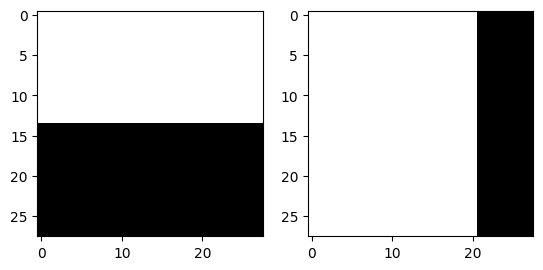

In [226]:
embedding = np.load('data_embedding.npy')
one_h_image_tensor = horizontal_boundary_tensor_image()
one_v_image_tensor = vertical_boundary_tensor_image()

one_h_image = one_h_image_tensor.numpy().reshape(28, 28)
one_v_image = one_v_image_tensor.numpy().reshape(28, 28)

plt.figure(figsize=(9, 2))

# Create figure and axes
fig, (ax1, ax2) = plt.subplots(1, 2)

# Plot images  
ax1.imshow(one_h_image, cmap='gray')
ax2.imshow(one_v_image, cmap='gray')

# Show plots
plt.show()

In [227]:
h_predictions = compute_similar_images(one_h_image_tensor, 5, embedding)
v_predictions = compute_similar_images(one_v_image_tensor, 5, embedding)
print(h_predictions)
print(v_predictions)

[[69, 158, 82, 83, 67]]
[[132, 146, 160, 90, 78]]


In [229]:
one_h = h_predictions[0][0]

print(len(data_loader))
print(type(images[one_h]))

5


IndexError: index 69 is out of bounds for dimension 0 with size 20

In [230]:
q = 0
for batch_idx, (train_img, target_img) in enumerate(data_loader):
    q +=1
    print(train_img.shape)
    print(q) 

torch.Size([20, 1, 28, 28])
1
torch.Size([20, 1, 28, 28])
2
torch.Size([20, 1, 28, 28])
3
torch.Size([20, 1, 28, 28])
4
torch.Size([20, 1, 28, 28])
5
